In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/50-epoch-resnet-result/training_log.csv
/kaggle/input/50-epoch-resnet-result/RESNET_35EP_0_DOC_001.h5
/kaggle/input/epoch-50-result-training/training_log.csv
/kaggle/input/epoch-50-result-training/RESNET_35EP_0_DOC_001.h5
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/

Improving Image Segmentation Accuracy Based on Residual Network (ResNet) Using Nearest Neighbor Upsampling for Brain Tumor Region Classification

Dataset Preparation


In this study, the dataset used is the Brain Tumor Segmentation 2020 dataset (BraTS 2020). All MRI scan images of brain tumor patients are available as NIfTI files (.nii.gz) and consist of several types of volumes obtained using different clinical protocols and various scanners from multiple institutions, including:

Original T1 volume (.t1.nii)
T1 volume after contrast (T1ce) (.t1ce.nii)
Original T2 volume (.t2.nii)
Fluid Attenuated Inversion Recovery (FLAIR) volume (.flair.nii)
Manual segmentation (.seg.nii)

All image datasets have been manually segmented by one to four annotators following the same annotation protocol, and their annotations were approved by experienced neuroradiologists. The annotations cover three tumor regions:

Tumor core or necrotic tumor area

Whole tumor or peritumoral edema area

Enhancing tumor area

Import Dataset

In [2]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

Data Quantity Analysis

In [3]:
import os

TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

# ------------------ TRAINING DATA ------------------
# Count folders in the training dataset
train_folders = [name for name in os.listdir(TRAIN_DATASET_PATH) if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, name))]
num_train_folders = len(train_folders)
print(f"\nNumber of folders in the training data: {num_train_folders} Folders")

# Count total data in the training dataset
total_train_data = sum([len(os.listdir(os.path.join(TRAIN_DATASET_PATH, folder))) for folder in train_folders])
print(f"Total data in the training data: {total_train_data} Data \n")

# ------------------ VALIDATION DATA ------------------
# Count folders in the validation dataset
val_folders = [name for name in os.listdir(VALIDATION_DATASET_PATH) if os.path.isdir(os.path.join(VALIDATION_DATASET_PATH, name))]
num_val_folders = len(val_folders)
print(f"\nNumber of folders in the validation data: {num_val_folders} Folders")

# Count total data in the validation dataset
total_val_data = sum([len(os.listdir(os.path.join(VALIDATION_DATASET_PATH, folder))) for folder in val_folders])
print(f"Total data in the validation data: {total_val_data} Data")



Number of folders in the training data: 369 Folders
Total data in the training data: 1845 Data 


Number of folders in the validation data: 125 Folders
Total data in the validation data: 500 Data


Data Visualization

Text(0.5, 1.0, 'Mask')

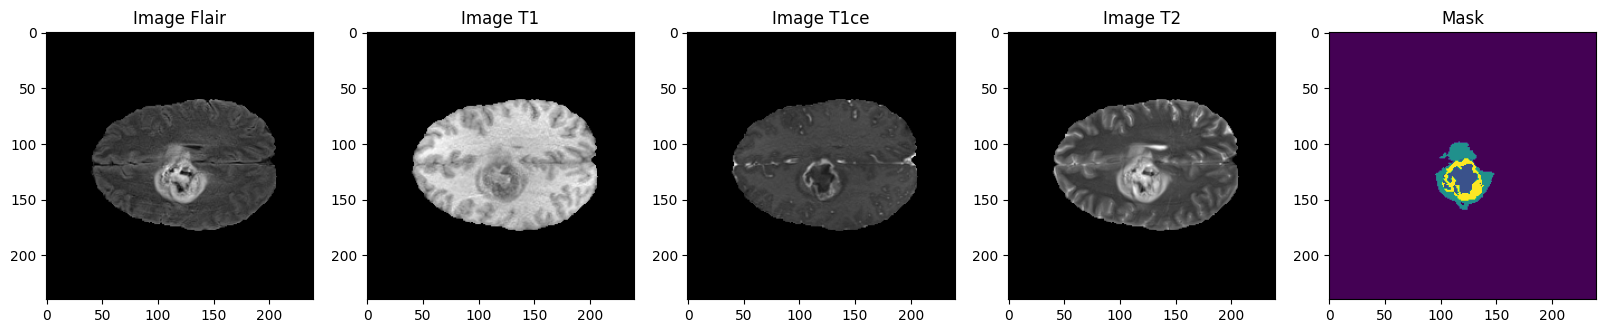

In [4]:
import nibabel as nib

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_022/BraTS20_Training_022_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_022/BraTS20_Training_022_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_022/BraTS20_Training_022_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_022/BraTS20_Training_022_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_022/BraTS20_Training_022_seg.nii').get_fdata()
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image Flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image T1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image T1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image T2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

Defining Segmentation Labels

In [5]:
SEGMENT_CLASSES = {
    0 : 'Not Tumor',
    1 : 'Necrotic/Core', 
    2 : 'Edema',
    3 : 'Enhancing'
}

Image Slice Analysis

In [6]:
import SimpleITK as sitk
import nibabel as nib

volume_path = TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii'

nii_image = nib.load(volume_path)

# Get the image dimensions
num_slices = nii_image.shape[2]  # The third dimension is the number of slices

print("Number of slices in a single volume:", num_slices)


Number of slices in a single volume: 155


In [7]:
VOLUME_SLICES = 100
VOLUME_START_AT = 55

Data Splitting

In [8]:
import os
from sklearn.model_selection import train_test_split

# Define the dataset paths
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

# Get list of directories in the training dataset
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Remove a directory with no segmentation data (if any)
train_and_val_directories.remove(TRAIN_DATASET_PATH + 'BraTS20_Training_355')

# Function to convert path list into IDs
def pathListIntoIds(dirList):
    x = []
    for i in range(len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

# Convert directories into IDs for training and testing
train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split into training and testing datasets (80:20)
train_ids, test_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)

# Get list of directories in the validation dataset
val_directories = [f.path for f in os.scandir(VALIDATION_DATASET_PATH) if f.is_dir()]

# Convert validation directories into IDs
val_ids = pathListIntoIds(val_directories)

# Print the split data
print(f"Number of training samples: {len(train_ids)}")
print(f"Number of testing samples: {len(test_ids)}")
print(f"Number of validation samples: {len(val_ids)}")


Number of training samples: 294
Number of testing samples: 74
Number of validation samples: 125


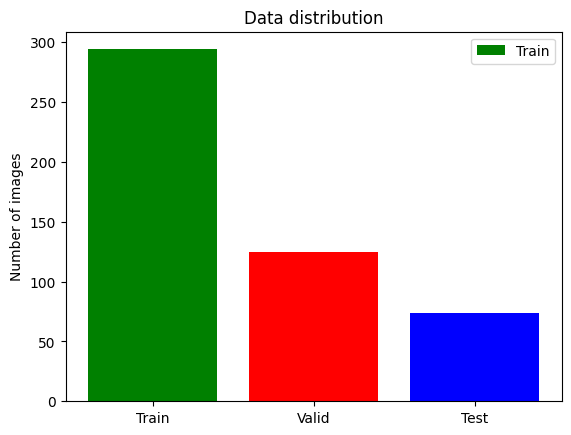

In [9]:
import matplotlib.pyplot as plt

def showDataLayout():
    # Plot bar chart for data distribution
    plt.bar(["Train", "Valid", "Test"],
            [len(train_ids), len(val_ids), len(test_ids)], 
            align='center', color=['green', 'red', 'blue'])
    
    # Adding labels for the bars
    plt.ylabel('Number of images')
    plt.title('Data distribution')
    
    # Adding the legend
    plt.legend(["Train", "Validation", "Test"], loc="upper right")

    # Show the plot
    plt.show()

# Call the function to display the plot
showDataLayout()


Data Preprocessing

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128

# Define an ImageDataGenerator with data augmentation options
datagen = ImageDataGenerator(
    rotation_range=30,  # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift the width of images
    height_shift_range=0.2,  # Randomly shift the height of images
    shear_range=0.2,  # Randomly apply shear transformations
    zoom_range=0.3,  # Randomly zoom in and out
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,     # Flip vertikal acak
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.datagen = datagen  # Use the defined ImageDataGenerator

    #jumlah_batch_per_epoch = panjang_total_dataset / ukuran_batch
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

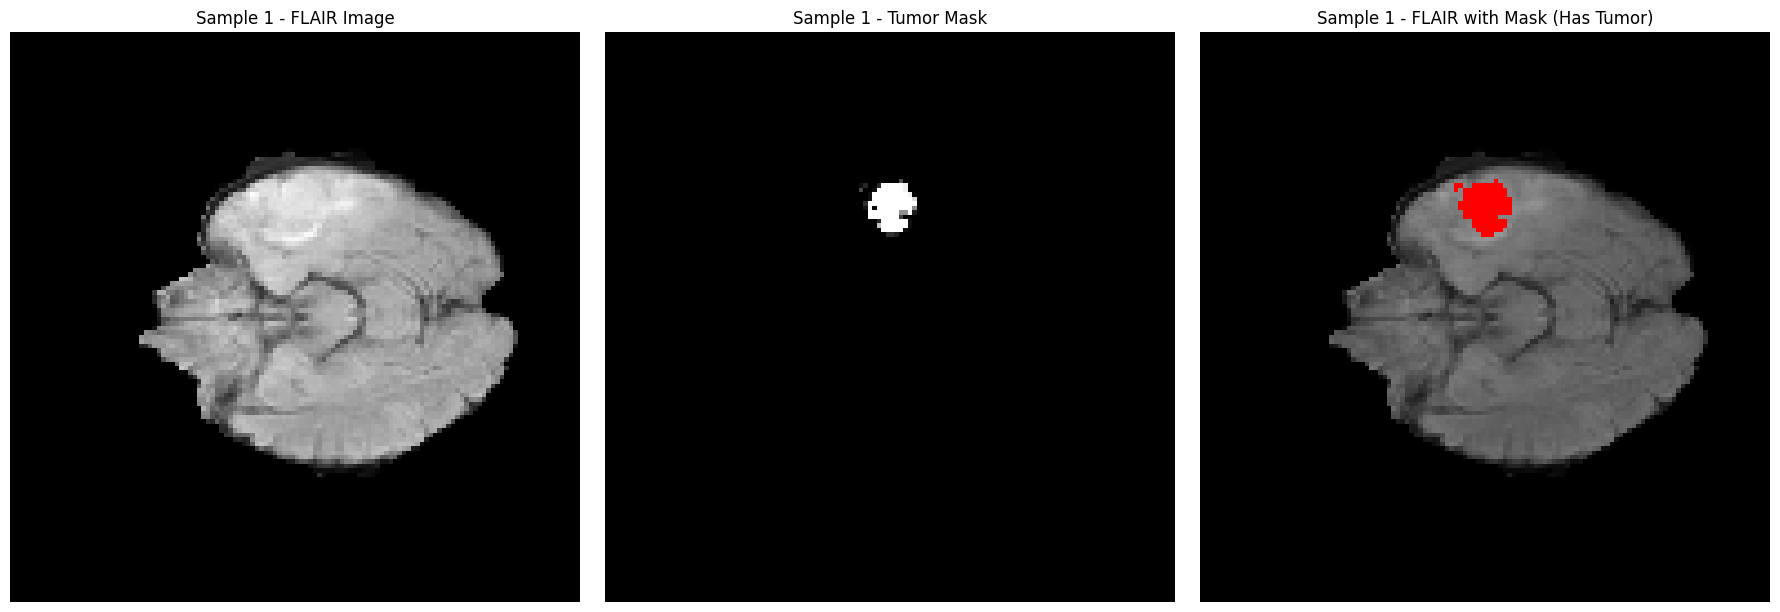

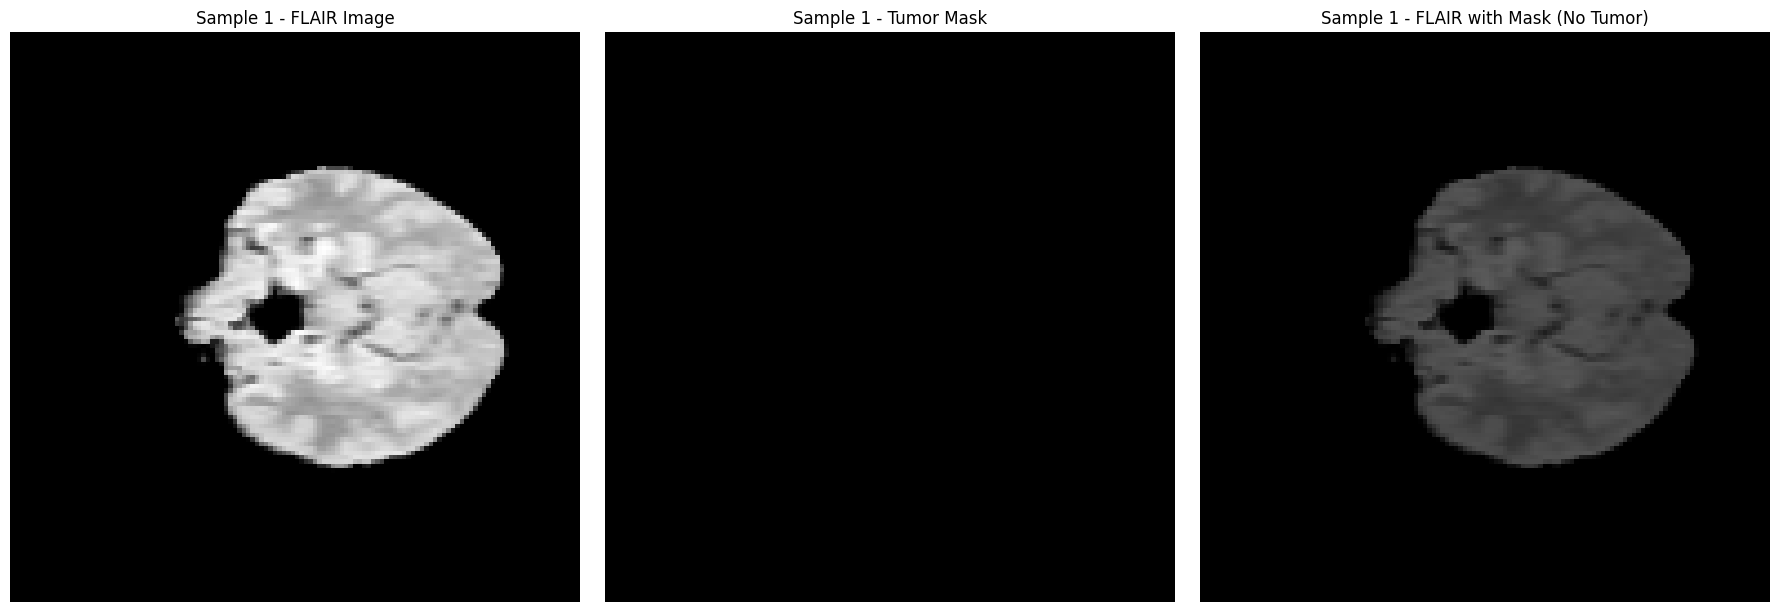

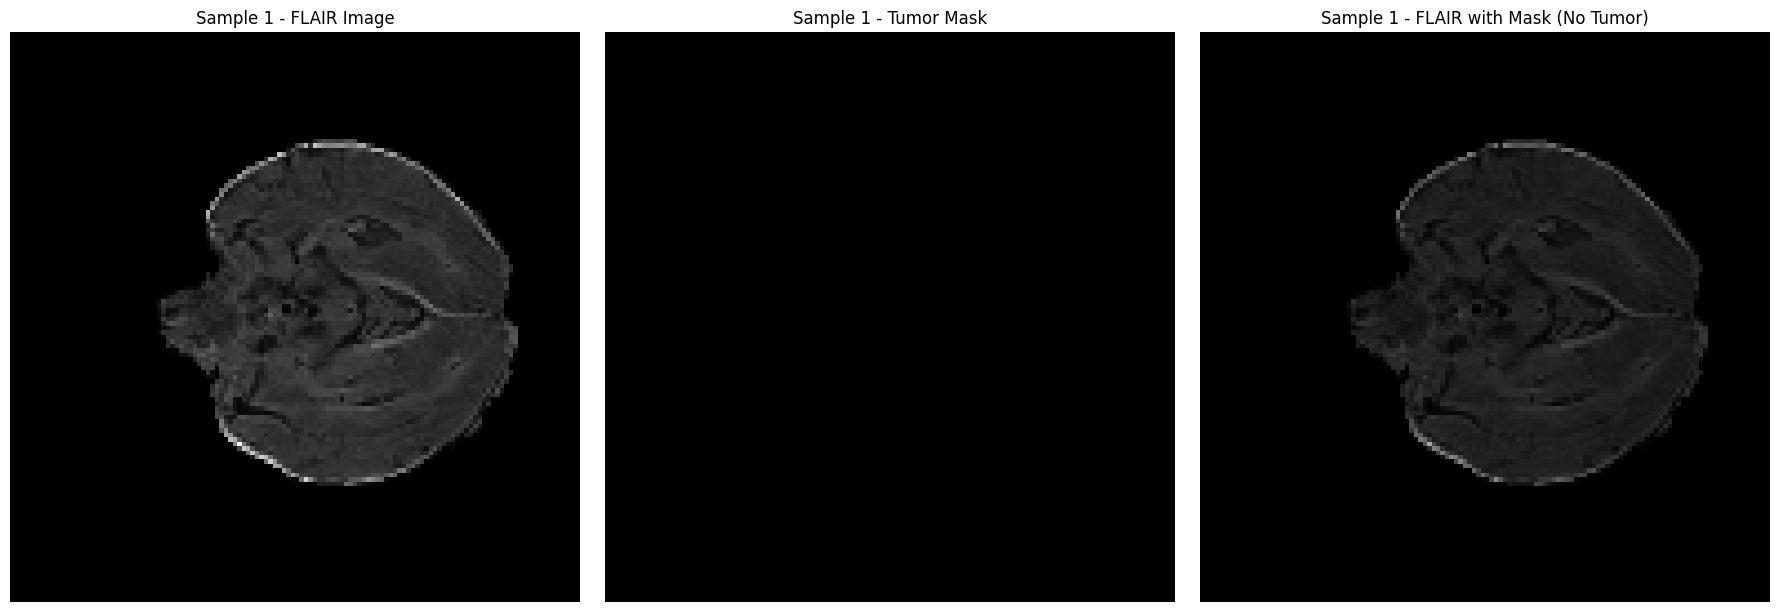

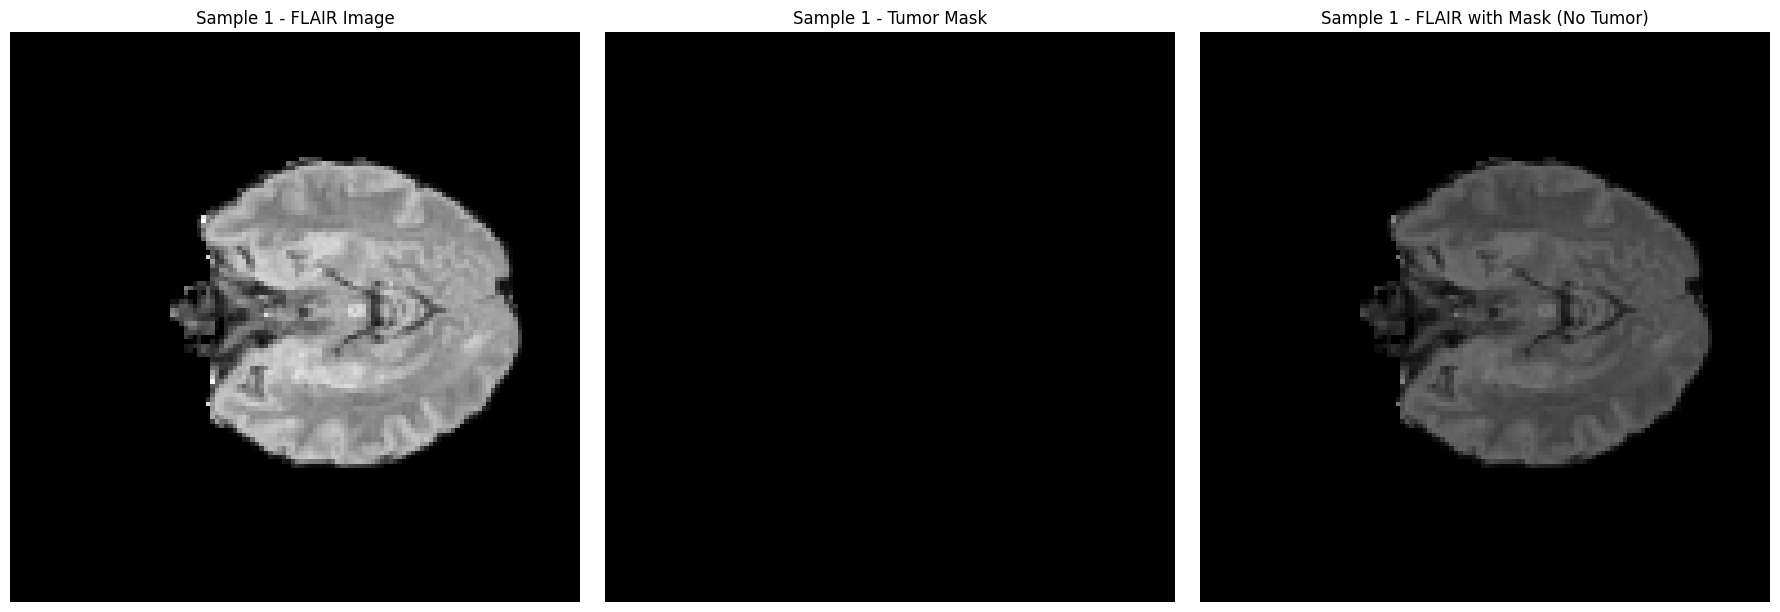

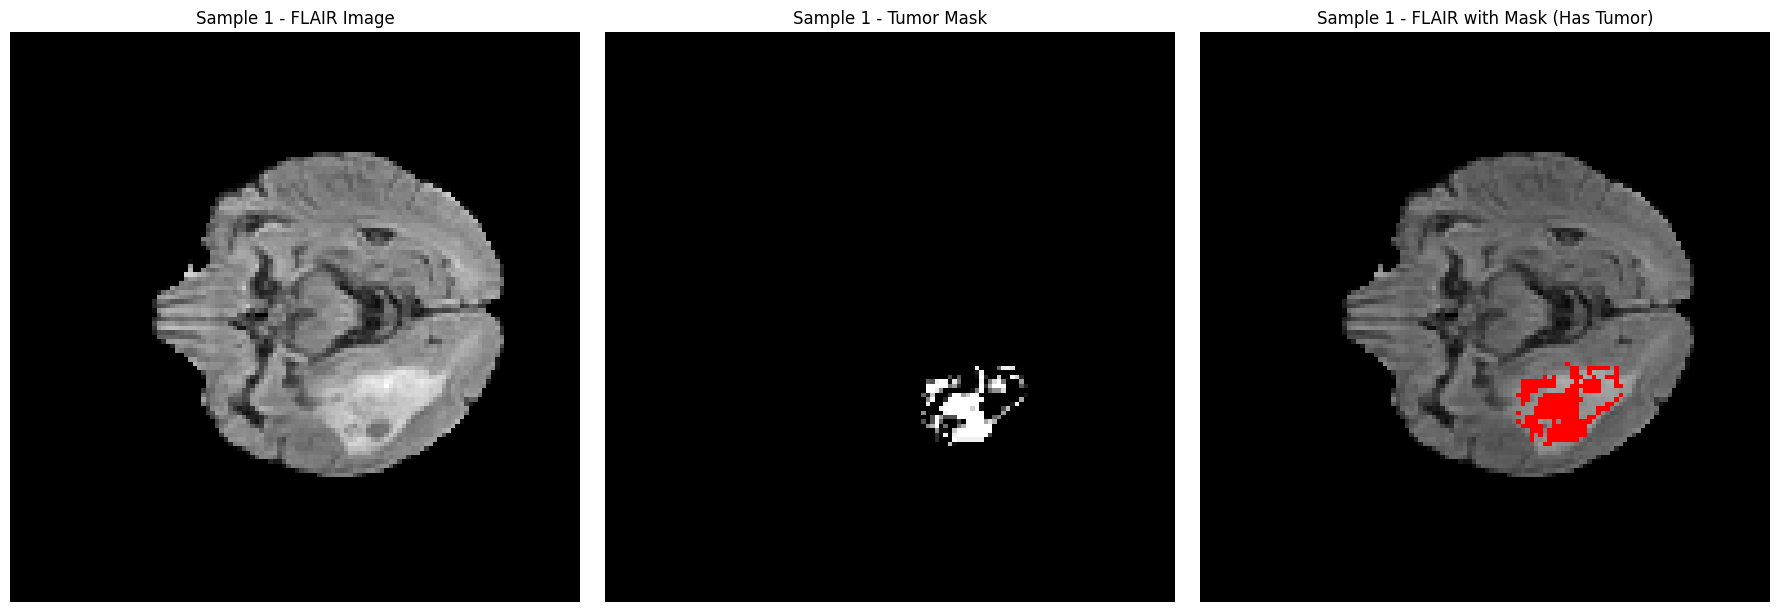

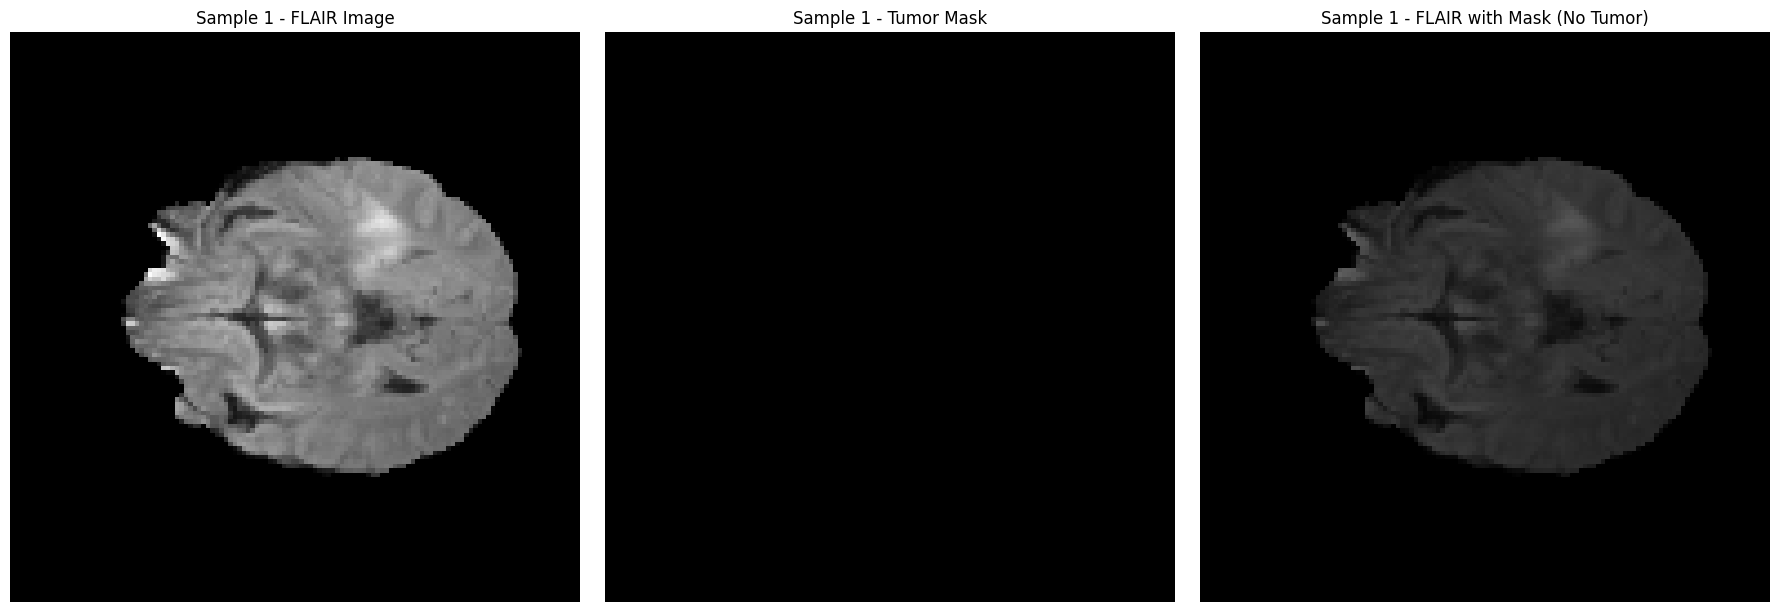

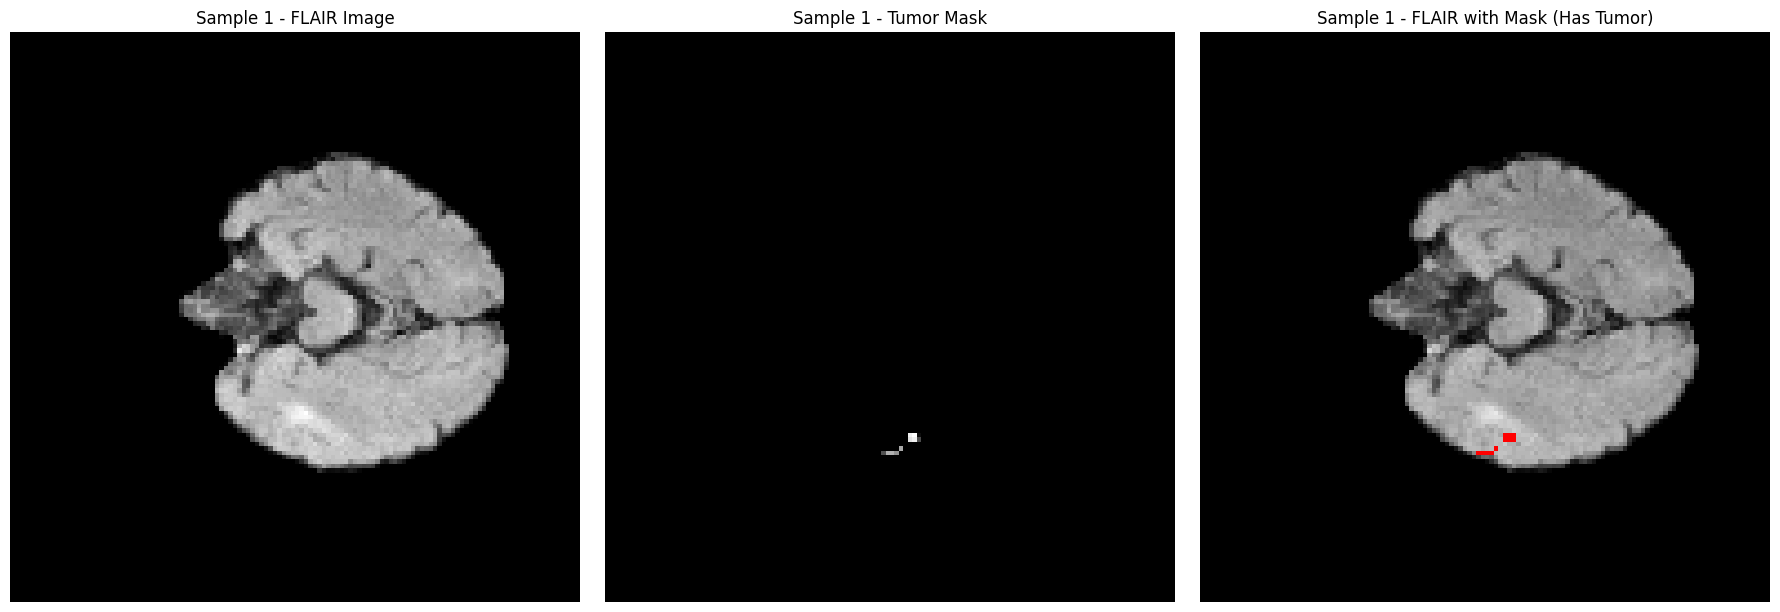

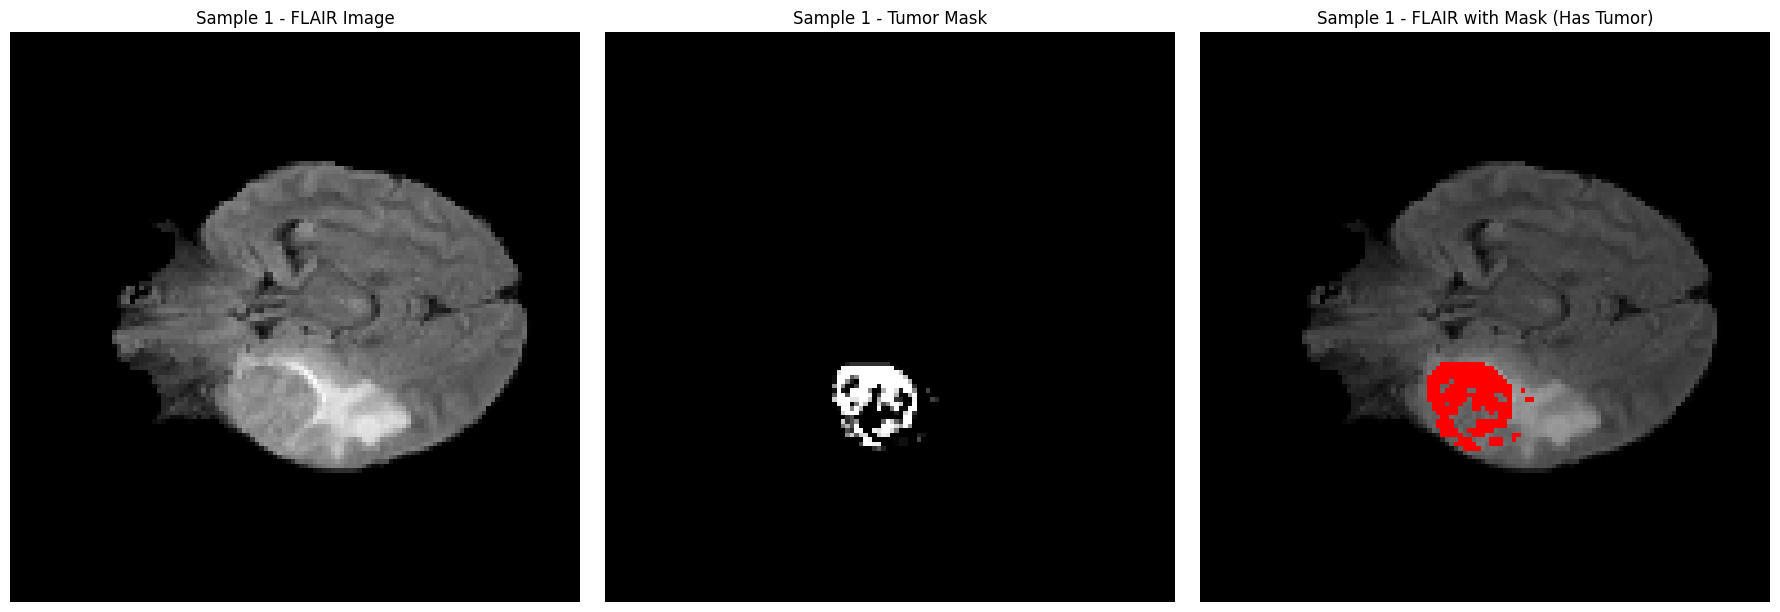

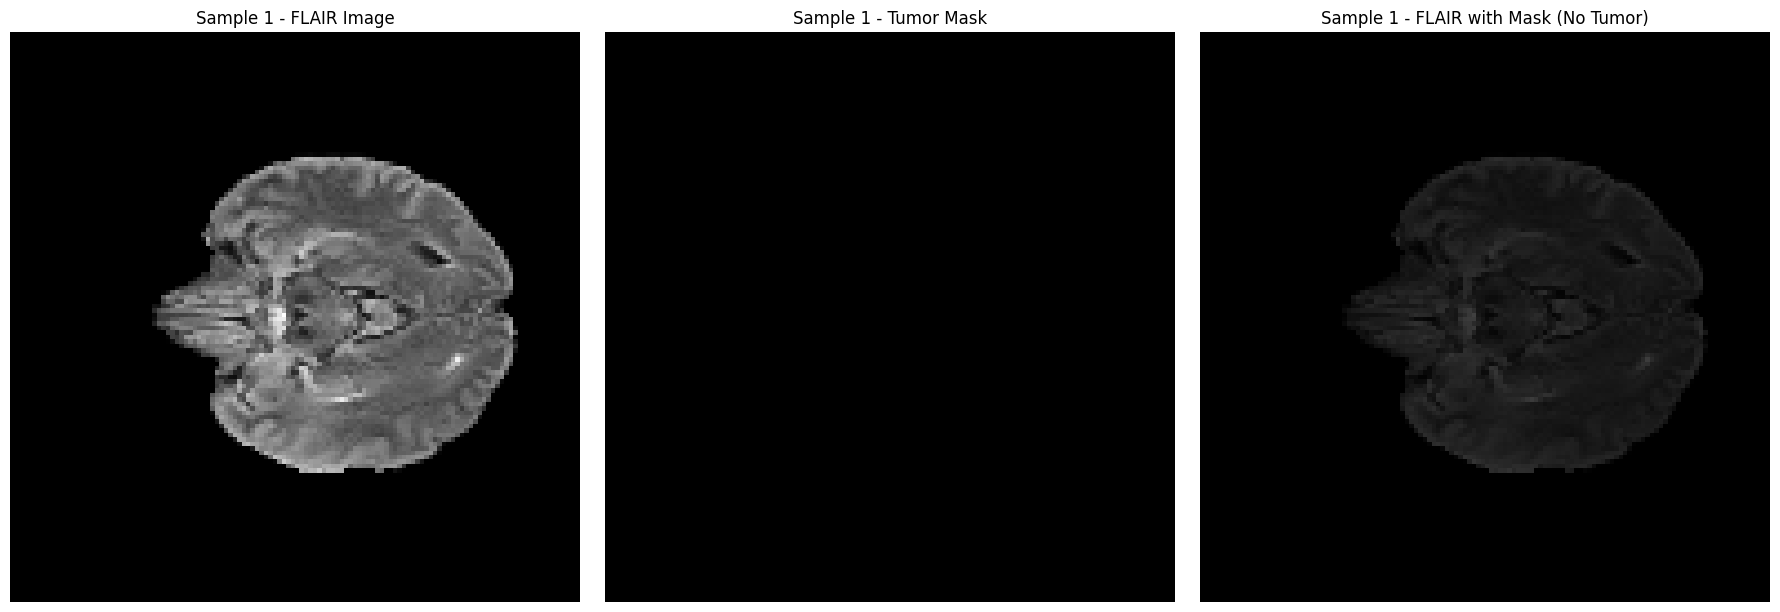

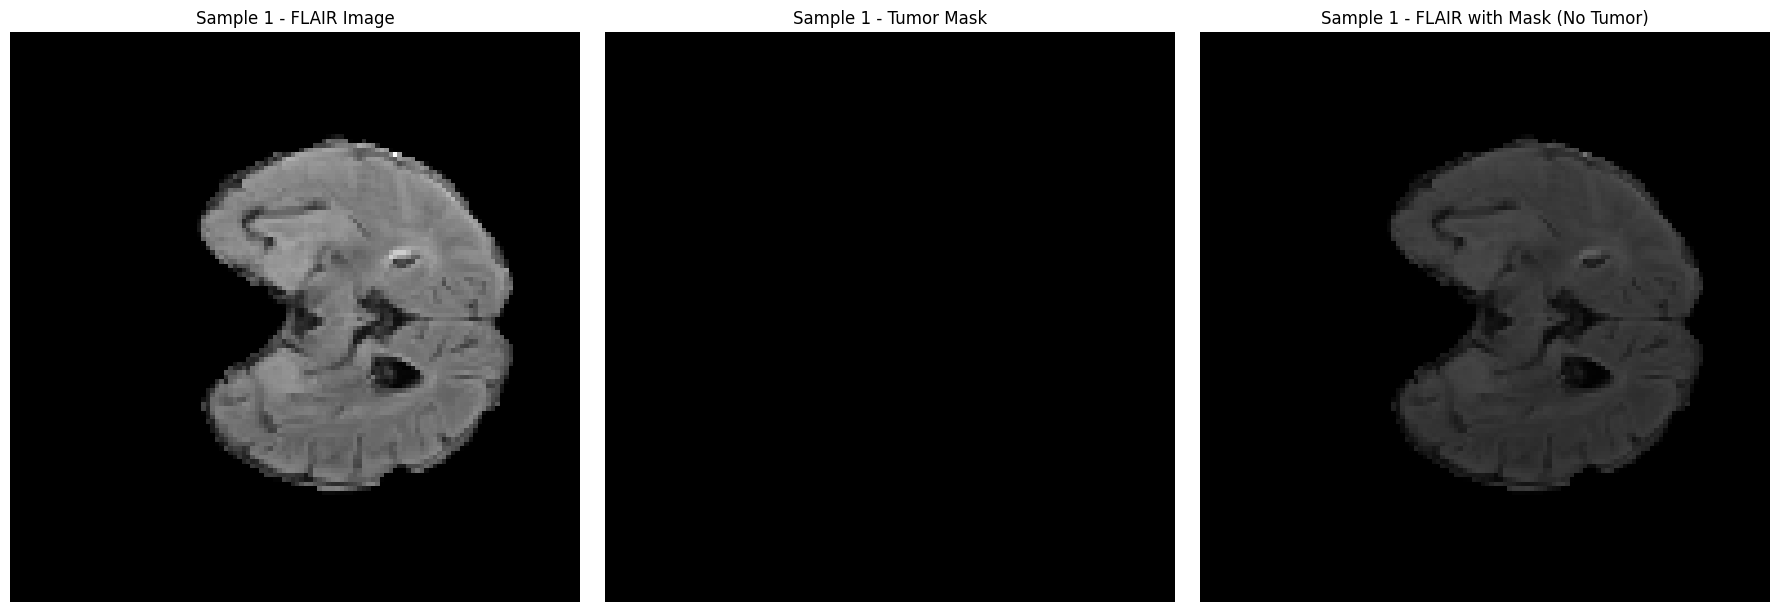

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Take some batches of data from the training generator
num_batches_to_display = 10  # Adjust as needed.
for batch_index in range(num_batches_to_display):
    batch_data, batch_labels = training_generator.__getitem__(batch_index)

    # Display some examples from the batch data
    num_samples_to_display = min(training_generator.batch_size, 4)  # Modify as needed
    for sample_index in range(num_samples_to_display):
        sample_image = batch_data[sample_index]
        sample_label = batch_labels[sample_index]

        # Check if the tumor is present or not (if any non-zero values in the label)
        tumor_present = "Has Tumor" if np.any(sample_label[:, :, 1] > 0) else "No Tumor"

        # Display the images in a row of subplots
        plt.figure(figsize=(18, 6))

        # Display original FLAIR image (first channel)
        plt.subplot(1, 3, 1)
        plt.imshow(sample_image[..., 0], cmap='gray')  # Display the first channel (e.g., FLAIR).
        plt.title(f'Sample {sample_index + 1} - FLAIR Image')
        plt.axis('off')

        # Display the tumor label/mask (second channel as a mask)
        plt.subplot(1, 3, 2)
        plt.imshow(sample_label[..., 1], cmap='gray')  # Display the "Has Tumor" mask (second channel).
        plt.title(f'Sample {sample_index + 1} - Tumor Mask')
        plt.axis('off')

        # Create an overlay of the mask on the original image (FLAIR image)
        combined_image = np.stack([sample_image[..., 0]] * 3, axis=-1)  # Convert grayscale to RGB
        combined_image[sample_label[..., 1] > 0] = [255, 0, 0]  # Apply red where the mask is present

        # Display the combined image with tumor presence label
        plt.subplot(1, 3, 3)
        plt.imshow(combined_image)
        plt.title(f"Sample {sample_index + 1} - FLAIR with Mask ({tumor_present})")
        plt.axis('off')

        # Show the plot
        plt.tight_layout()
        plt.show()


Training Model Definition

Model 1 - ResNet without Nearest Neighbor

Model 2 - Optimized ResNet with Nearest Neighbor

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation, Add
from tensorflow.keras.regularizers import l2
import numpy as np
import tensorflow as tf

# Define input shape
input_shape = (128, 128, 4)
n_classes = 4

# Function to build the resnet (encoder)
def resnet_block(input_tensor, filters, kernel_size=(3, 3), padding="same", stride=1):
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    if input_tensor.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define input layer
inputs = Input(input_shape)

# Encoder
c1 = resnet_block(inputs, 64)
p1 = MaxPooling2D((2, 2))(c1)
c2 = resnet_block(p1, 128)
p2 = MaxPooling2D((2, 2))(c2)
c3 = resnet_block(p2, 256)
p3 = MaxPooling2D((2, 2))(c3)
c4 = resnet_block(p3, 512)
p4 = MaxPooling2D((2, 2))(c4)

# Bottleneck
b = resnet_block(p4, 1024)

# Output layer
outputs = Conv2D(n_classes, (1, 1), activation="softmax")(b)

# Create model 1
model1 = Model(inputs, outputs)

# Print summary of the model
model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 19,570,244 (74.65 MB)

 Trainable params: 19,558,340 (74.61 MB)

 Non-trainable params: 11,904 (46.50 KB)

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation, Add
from tensorflow.keras.regularizers import l2
import numpy as np
import tensorflow as tf

# Define input shape
input_shape = (128, 128, 4)  # 4 channels (e.g., FLAIR, T1, T1ce, T2)
n_classes = 4  # Number of output classes

# Function to build resnet block (encoder)
def resnet_block(input_tensor, filters, kernel_size=(3, 3), padding="same", stride=1):
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    
    # If input channels do not match output channels, apply 1x1 convolution to match the shape
    if input_tensor.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding=padding)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor
    
    # Add the shortcut (skip connection)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Function to build upsampling block (decoder)
def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)  # Upsampling by a factor of 2
    concat = concatenate([us, skip], axis=-1)  # Concatenate the upsampled feature map with the skip connection
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu", kernel_regularizer=l2(1e-4))(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu", kernel_regularizer=l2(1e-4))(c)
    return c

# Define input layer
inputs = Input(input_shape)

# Encoder: Apply ResNet blocks followed by max pooling
c1 = resnet_block(inputs, 64)
p1 = MaxPooling2D((2, 2))(c1)
c2 = resnet_block(p1, 128)
p2 = MaxPooling2D((2, 2))(c2)
c3 = resnet_block(p2, 256)
p3 = MaxPooling2D((2, 2))(c3)
c4 = resnet_block(p3, 512)
p4 = MaxPooling2D((2, 2))(c4)

# Bottleneck: Central block with larger filters
b = resnet_block(p4, 1024)

# Decoder: Upsample using up_block and concatenate with skip connections
u4 = up_block(b, c4, 512)
u3 = up_block(u4, c3, 256)
u2 = up_block(u3, c2, 128)
u1 = up_block(u2, c1, 64)

# Output layer with softmax activation for multi-class segmentation
outputs = Conv2D(n_classes, (1, 1), activation="softmax")(u1)

# Create model
model2 = Model(inputs, outputs)

# Print model summary
model2.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      2,368 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 128, 128,  │          0 │ add_5[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      8,320 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_20[0][0] 

 Total params: 32,102,084 (122.46 MB)

 Trainable params: 32,090,180 (122.41 MB)

 Non-trainable params: 11,904 (46.50 KB)

Model Training

In [14]:
# Compile the model
model1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[
        'accuracy'
    ]
)

model2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[
        'accuracy'
    ]
)

In [15]:
import keras
from keras.callbacks import ReduceLROnPlateau, CSVLogger
import keras.backend as K

# Define the path to save the log file
log_file_path = '/kaggle/working/training_log.csv'

# Define other callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='auto'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_weights_{epoch:02d}-{val_loss:.6f}.weights.h5', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True),
    tf.keras.callbacks.CSVLogger(log_file_path, separator=',', append=False)   
]

# Custom function to resize target labels to the output shape
def resize_target_labels(y, target_size=(8, 8)):
    resized_y = tf.image.resize(y, target_size)  # Resize ground truth to match output shape
    return resized_y

# # Training code
# history = model1.fit(training_generator,
#                     epochs=15,
#                     batch_size=16,
#                     steps_per_epoch=len(train_ids),
#                     callbacks=callbacks,
#                     validation_data=valid_generator
#                     )

# history = model2.fit(training_generator,
#                     epochs=15,
#                     batch_size=16,
#                     steps_per_epoch=len(train_ids),
#                     callbacks=callbacks,
#                     validation_data=valid_generator
#                     )

# # Save the model
# model.save("RESNET_35EP_0_DOC_001.h5")

Training Results of Model 1

ResNet without Nearest Neighbor Upsampling Epoch 15.

In [16]:
import os
print(os.listdir('/kaggle/input/'))


['50-epoch-resnet-result', 'epoch-50-result-training', 'brats20-dataset-training-validation']


In [17]:
# import pandas as pd
# import tensorflow as tf
# import keras
# import matplotlib.pyplot as plt

# # Load the model from the correct Kaggle input path
# model_one_15 = keras.models.load_model('/kaggle/input/15-epoch-resnet-only/RESNET_ONLY_15_EPOCH.h5', 
#                                       custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

# # Load the training log from the correct Kaggle input path
# model_one_15_history = pd.read_csv('/kaggle/input/15-epoch-resnet-only/training_log_resnet_only_15_epoch.csv', sep=',', engine='python')

# history_1 = model_one_15_history

# # Extract accuracy and loss values
# acc = history_1['accuracy']
# val_acc = history_1['val_accuracy']
# epoch = range(len(acc))

# loss = history_1['loss']
# val_loss = history_1['val_loss']

# # Plot training and validation accuracy and loss
# f, ax = plt.subplots(1, 2, figsize=(16, 8))

# # Accuracy plot
# ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
# ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
# ax[0].legend()

# # Loss plot
# ax[1].plot(epoch, loss, 'b', label='Training Loss')
# ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
# ax[1].legend()

# plt.show()


ResNet without Nearest Neighbor Upsampling at Epoch 35.

In [18]:
# import pandas as pd

# model_one_35 = keras.models.load_model('../input/35-epoch-resnet-only/RESNET_ONLY_35_EPOCH.h5', 
#                                    custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

# model_one_35_history = pd.read_csv('../input/35-epoch-resnet-only/training_log_resnet_only_35_epoch.csv', sep=',', engine='python')

# #history

# history_2 = model_one_35_history

# acc = history_2['accuracy']
# val_acc = history_2['val_accuracy']

# epoch = range(len(acc))

# loss = history_2['loss']
# val_loss = history_2['val_loss']

# f,ax=plt.subplots(1,2,figsize=(16,8))

# ax[0].plot(epoch,acc,'b',label='Training Accuracy')
# ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
# ax[0].legend()

# ax[1].plot(epoch,loss,'b',label='Training Loss')
# ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
# ax[1].legend()

# plt.show()

ResNet without Nearest Neighbor Upsampling at Epoch 50.

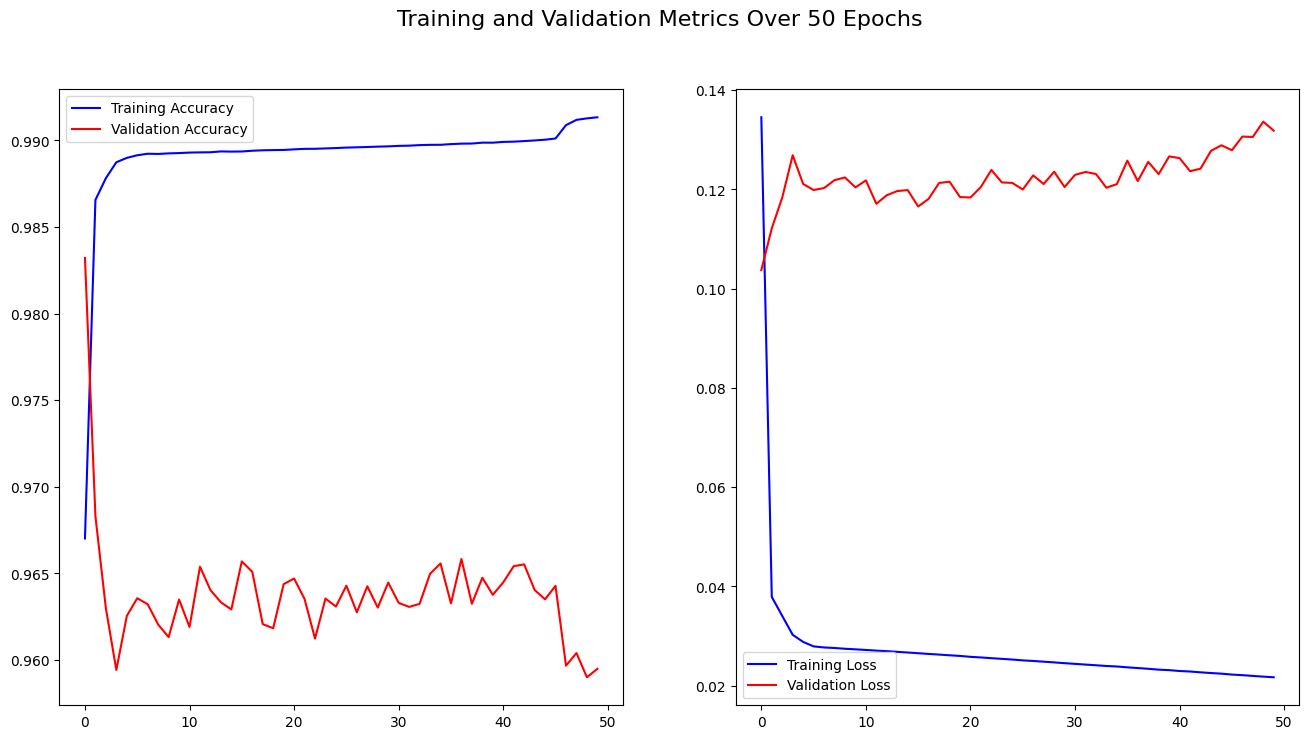

In [19]:
import pandas as pd

model_one_50 = keras.models.load_model('../input/50-epoch-resnet-result/RESNET_35EP_0_DOC_001.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

model_one_50_history = pd.read_csv('../input/50-epoch-resnet-result/training_log.csv', sep=',', engine='python')

#history

history_3 = model_one_50_history

acc = history_3['accuracy']
val_acc = history_3['val_accuracy']

epoch = range(len(acc))

loss = history_3['loss']
val_loss = history_3['val_loss']


f,ax=plt.subplots(1,2,figsize=(16,8))
f.suptitle("Training and Validation Metrics Over 50 Epochs", fontsize=16)
# print("Training Accuracy" , acc)
# print("Validation Accuracy" , val_loss)
# print("Training Loss" , loss)
# print("Validation Loss" , val_loss)

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

plt.show()

Training Results of Model 2

ResNet Optimized with Nearest Neighbor Upsampling Epoch 15

In [20]:
# import pandas as pd

# model_two_15 = keras.models.load_model('../input/15-epoch-resnet-upsampling/RESNET_UPSAMPLING_15_EPOCH.h5', 
#                                    custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

# model_two_15_history = pd.read_csv('../input/15-epoch-resnet-upsampling/training_log_resnet_upsampling_15_epoch.csv', sep=',', engine='python')

# #history

# history_4 = model_two_15_history

# acc = history_4['accuracy']
# val_acc = history_4['val_accuracy']

# epoch = range(len(acc))

# loss = history_4['loss']
# val_loss = history_4['val_loss']

# f,ax=plt.subplots(1,2,figsize=(16,8))

# ax[0].plot(epoch,acc,'b',label='Training Accuracy')
# ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
# ax[0].legend()

# ax[1].plot(epoch,loss,'b',label='Training Loss')
# ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
# ax[1].legend()

# plt.show()

ResNet Optimized with Nearest Neighbor Upsampling Epoch 35

In [21]:
# import pandas as pd

# model_two_35 = keras.models.load_model('../input/epoch-35-result-training/RESNET_35EP_0_DOC_001.h5', 
#                                    custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

# model_two_35_history = pd.read_csv('../input/epoch-35-result-training/training_log.csv', sep=',', engine='python')

# #history

# history_5 = model_two_35_history

# acc = history_5['accuracy']
# val_acc = history_5['val_accuracy']

# epoch = range(len(acc))

# loss = history_5['loss']
# val_loss = history_5['val_loss']

# f,ax=plt.subplots(1,2,figsize=(16,8))

# ax[0].plot(epoch,acc,'b',label='Training Accuracy')
# ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
# ax[0].legend()

# ax[1].plot(epoch,loss,'b',label='Training Loss')
# ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
# ax[1].legend()

# plt.show()

ResNet Optimized with Nearest Neighbor Upsampling Epoch 50

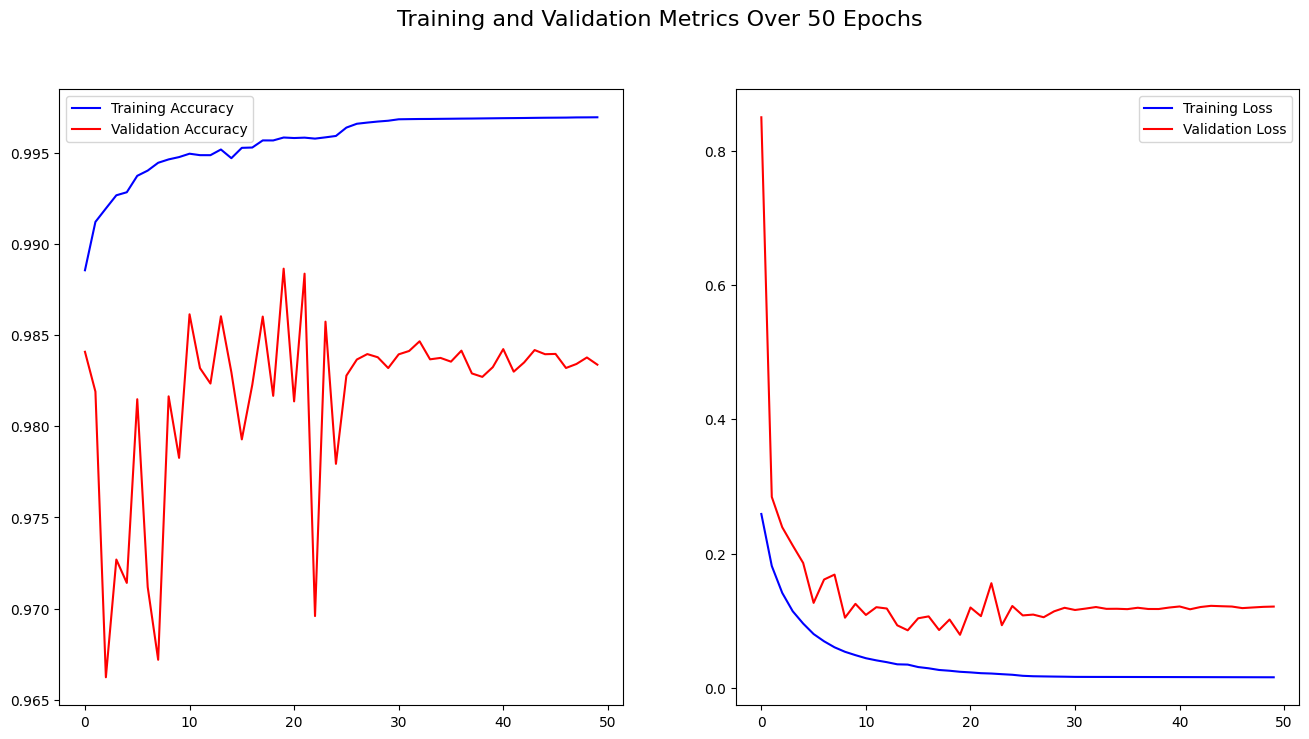

In [22]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# Load the trained model
model_two_50 = keras.models.load_model('../input/epoch-50-result-training/RESNET_35EP_0_DOC_001.h5', 
                                       custom_objects={'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

# Load training history log
model_two_50_history = pd.read_csv('../input/epoch-50-result-training/training_log.csv', sep=',', engine='python')

# Extracting the history data
history_6 = model_two_50_history

# Extract accuracy and loss
acc = history_6['accuracy']
val_acc = history_6['val_accuracy']
epoch = range(len(acc))

loss = history_6['loss']
val_loss = history_6['val_loss']

# Plot training and validation metrics
f, ax = plt.subplots(1, 2, figsize=(16, 8))
f.suptitle("Training and Validation Metrics Over 50 Epochs", fontsize=16)

# Plot accuracy
ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

plt.show()


Data Segmentation Testing.

In [23]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
    Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [24]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob(i + '/*' + mriType + '*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader(glob.glob(i + '/*seg*')[0])

        # for each slice in 3D volume, find also its mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE),
                                  interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE),
                                  interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

def showPredictsById(case, start_slice=50):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    edema = p[:, :, :, 1]
    core = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):  # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                         cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('all classes')
    axarr[2].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[2].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[3].imshow(core[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[4].imshow(enhancing[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    axarr[5].imshow(cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)))
    axarr[5].title.set_text('Mask Validation')
    plt.show()
    

def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model_two_50.predict(X / np.max(X), verbose=1)


def showPredictsByIdResNet(case, start_slice=50):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPathResNet(path, case)

    edema = p[:, :, :, 1]
    core = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):  # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                         cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('all classes')
    axarr[2].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[2].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[3].imshow(core[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[4].imshow(enhancing[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    axarr[5].imshow(cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)))
    axarr[5].title.set_text('Mask Validation')
    plt.show()
    
def predictByPathResNet(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    ce = nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model_one_50.predict(X / np.max(X), verbose=1)


ResNet without Nearest Neighbor Upsampling


Case 033



I0000 00:00:1731224974.286707      98 service.cc:145] XLA service 0x7ba704002ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731224974.286765      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/4 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step

I0000 00:00:1731224980.128216      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


<Figure size 1800x5000 with 0 Axes>

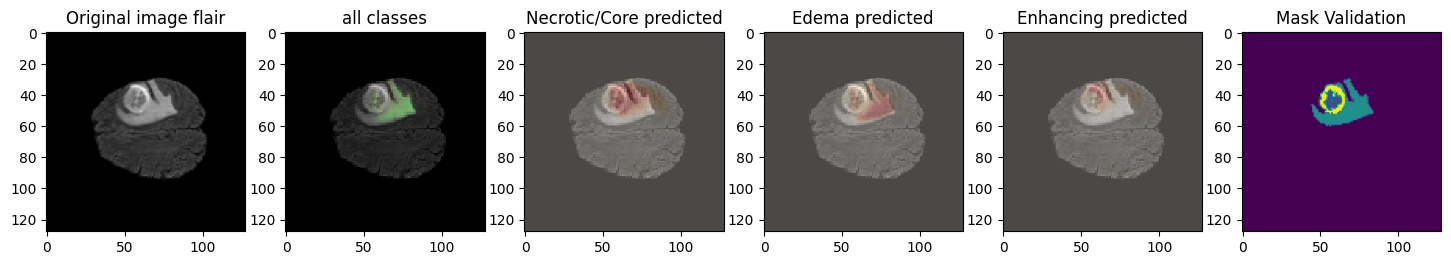


Case 075

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

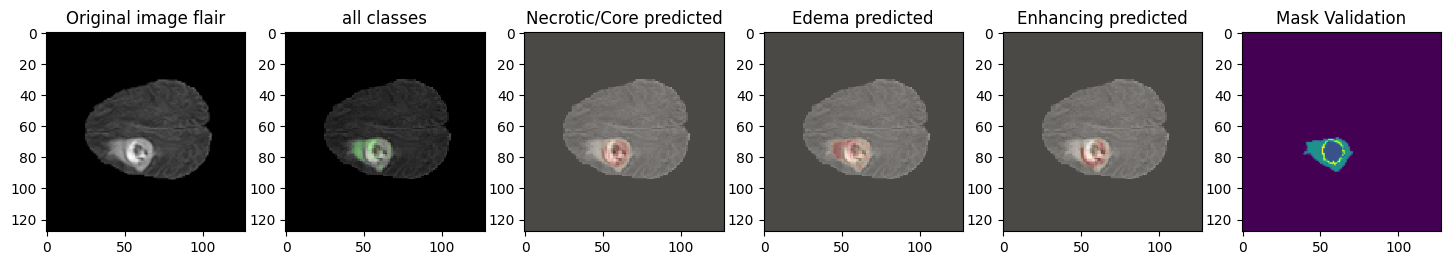


Case 230

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

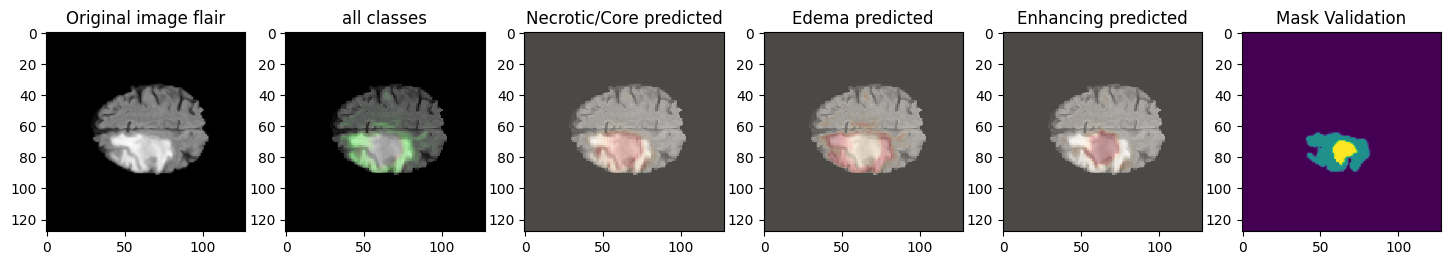


Case 302

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

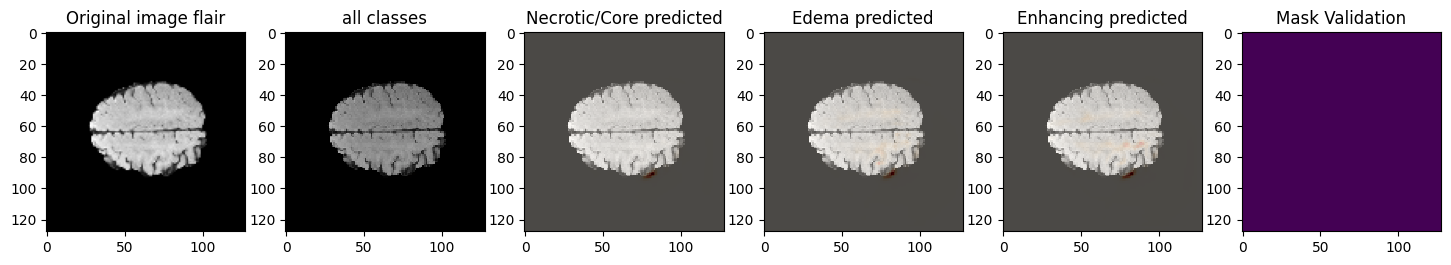


ResNet optimized with Nearest Neighbor Upsampling


Case 033

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


<Figure size 1800x5000 with 0 Axes>

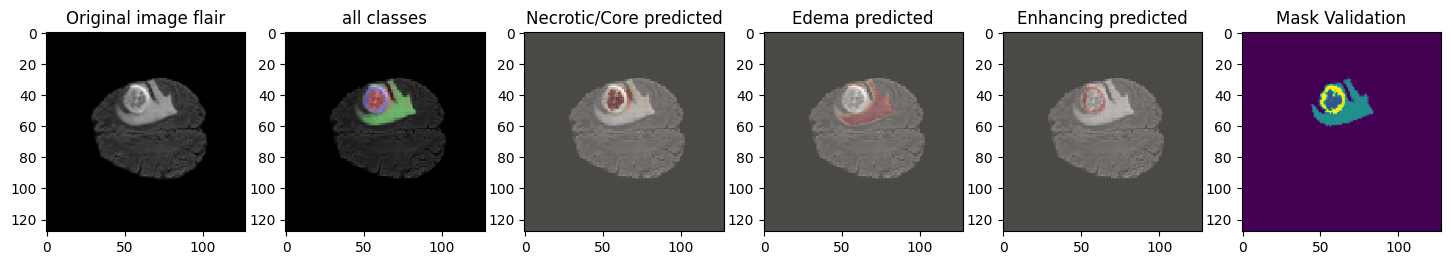


Case 075

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

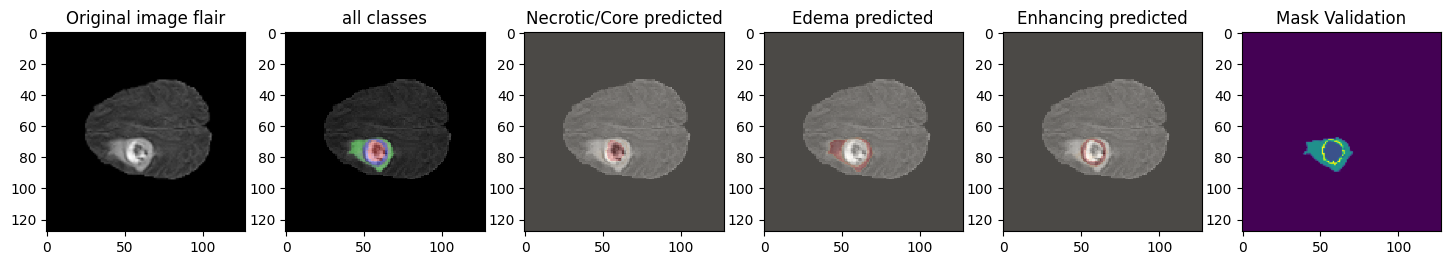


Case 230

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

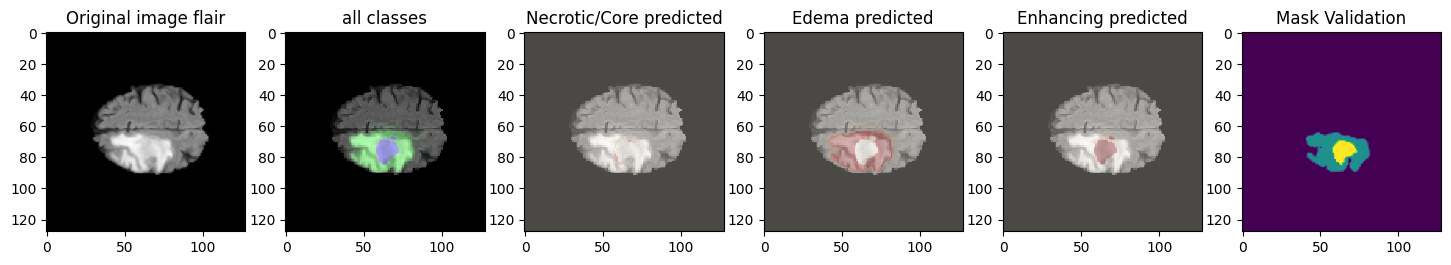


Case 302

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

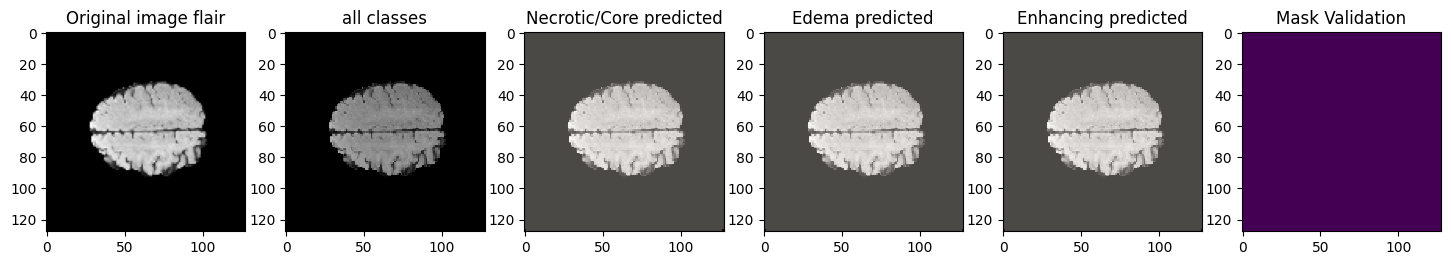

In [25]:
def fixedIndicesPredictAndShow(case_ids, model_predict_function):
    for case_id in case_ids:
        case = case_id[-3:]
        print(f"\nCase {case}\n")
        model_predict_function(case=case)

fixed_cases1 = ['BraTS20_Training_033']
fixed_cases2 = ['BraTS20_Training_075']
fixed_cases3 = ['BraTS20_Training_230']
fixed_cases4 = ['BraTS20_Training_302']

print("\nResNet without Nearest Neighbor Upsampling\n")
fixedIndicesPredictAndShow(case_ids=fixed_cases1, model_predict_function=showPredictsByIdResNet)
fixedIndicesPredictAndShow(case_ids=fixed_cases2, model_predict_function=showPredictsByIdResNet)
fixedIndicesPredictAndShow(case_ids=fixed_cases3, model_predict_function=showPredictsByIdResNet)
fixedIndicesPredictAndShow(case_ids=fixed_cases4, model_predict_function=showPredictsByIdResNet)

print("\nResNet optimized with Nearest Neighbor Upsampling\n")
fixedIndicesPredictAndShow(case_ids=fixed_cases1, model_predict_function=showPredictsById)
fixedIndicesPredictAndShow(case_ids=fixed_cases2, model_predict_function=showPredictsById)
fixedIndicesPredictAndShow(case_ids=fixed_cases3, model_predict_function=showPredictsById)
fixedIndicesPredictAndShow(case_ids=fixed_cases4, model_predict_function=showPredictsById)


Testing and Evaluation of Training Data.

Model 1: ResNet without Nearest Neighbor Upsampling.

In [26]:
# model_one_15.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'] )

# print("Evaluasi Model 1 pada 15 epoch")
# result_1 = model_one_15.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# print("test loss, test acc:", result_1)

In [27]:
# model_one_35.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'] )

# print("Evaluasi Model 1 pada 35 epoch")
# result_2 = model_one_35.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# print("test loss, test acc:", result_2)

In [28]:
model_one_50.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])

print("Evaluating Model 1 for 50 epochs")
result_3 = model_one_50.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test accuracy:", result_3)


Evaluating Model 1 for 50 epochs


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.9675 - loss: 0.0887
test loss, test accuracy: [0.08873730897903442, 0.9681759476661682]


Model 2: ResNet Optimized with Upsampling.

In [29]:
# model_two_15.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'] )

# print("Evaluasi Model 2 pada 15 epoch")
# result_1 = model_two_15.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# print("test loss, test acc:", result_1)

In [30]:
# model_two_35.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'] )

# print("Evaluasi Model 2 pada 35 epoch")
# result_2 = model_two_35.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# print("test loss, test acc:", result_2)

In [31]:
model_two_50.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])

print("Evaluating Model 2 for 50 epochs")
result_3 = model_two_50.evaluate(test_generator, batch_size=100, callbacks=callbacks)
print("test loss, test accuracy:", result_3)


Evaluating Model 2 for 50 epochs
74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - accuracy: 0.9826 - loss: 0.1025
test loss, test accuracy: [0.09965222328901291, 0.9823755025863647]
